# Analysis of 600 of the Voltage Signal After the Capacitor was fitted

In [1]:
import altair as alt
import numpy as np
import pandas as pd

from src.data_processing import calibrate_data, create_data_from_entry, unstable_seconds, flatten_data, average_data
from src.vizualization import generate_stability_rules, LINE_COLOUR

# Render altair charts correctly
alt.renderers.enable('notebook')

# Store the altair char json separately and not in the notebook 
# to reduce notebook size
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Load and clean data

First we load, clean and calibrate the raw data obtained by camonitoring the 

In [2]:
def clean_camonitored_data(data):
    """
    Cleans file produced from camonitoring a PV.

    Args:
        data (pandas Dataframe): Pandas Dataframe to be parsed.
    Returns:
        cleaned_dataframe (Dataframe): Cleaned dataframe
    """
    columns = ["PV name", "Date", "Time", "NELM"]
    columns.extend(list(range(1, 100 + 1)))
    data.columns = columns

    data["Datetime"] = pd.to_datetime(data["Date"] + ' ' + data["Time"])

    new_columns = ["Datetime"]
    new_columns.extend(list(range(1, 100 + 1)))
    cleaned_dataframe = data[new_columns]
    
    return cleaned_dataframe

data = pd.read_csv("C:\\Users\\olz75487\\Documents\\muonfe\\data\\raw\\2018-11-09-voltage-data.txt", 
                   delim_whitespace=True, header=None, nrows=600)

data = clean_camonitored_data(data)
calibrated_data = calibrate_data(data, 20)
calibrated_data.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,Datetime
0,92.6090,93.7440,92.6600,93.6674,92.6792,93.6930,92.6728,93.6994,92.7046,93.5974,...,92.9852,93.3678,92.9406,93.4124,92.9470,93.3870,92.9088,93.4380,92.8704,2018-11-09 10:46:08.559401
1,92.8194,93.5272,92.8130,93.5910,92.7876,93.5718,92.8068,93.5400,92.8386,93.5974,...,93.9990,92.3922,93.9798,92.3412,94.0182,92.3348,93.9926,92.4368,94.0372,2018-11-09 10:46:09.754002
2,96.3072,90.1096,96.3390,90.1096,96.2626,90.1160,96.3136,90.0842,96.3836,90.1032,...,89.8800,96.4794,89.9312,96.4602,89.9566,96.4920,89.8482,96.5048,89.9502,2018-11-09 10:46:10.942502
3,90.4284,95.9438,90.4156,95.9564,90.3838,96.0138,90.4412,95.9310,90.3902,95.9756,...,96.3136,90.0394,96.3262,90.0332,96.2816,90.0586,96.2752,90.0268,96.3136,2018-11-09 10:46:12.132639
4,95.4782,90.9130,95.4400,90.8938,95.4974,90.8366,95.5166,90.8366,95.5548,90.7918,...,90.2052,96.1414,90.1926,96.2052,90.1032,96.2242,90.1542,96.2052,90.1288,2018-11-09 10:46:13.315691


We can now save this cleaned file to load later.

In [3]:
calibrated_data.to_csv(os.path.join(os.getcwd(), "..", "data", "processed", "post-capacitor-cleand-calibrated-voltage-data.csv"), index=None)

## Analysis of 600 seconds

### Raw data Analysis

Now we flatten each array of data by asigning a time stamp to each element of the array in the following way:

- Given a row,  finding the time delta between this row and the next row,
- Dividing this time delta by the number of elements in an array (100 in this case) to get the time delta between readings.
- For each element of the array, multiple the time delta between readings and the position of the element in the array and add this to the time reading for the row.

Note this assumes that readings are sampled equally spaced apart.

In [4]:
flatten_raw_data = flatten_data(calibrated_data)
flatten_raw_data.head()

,Datetime,Value
0,2018-11-09 10:46:08.559401000,92.6090
1,2018-11-09 10:46:08.571347010,93.7440
2,2018-11-09 10:46:08.583293020,92.6600
3,2018-11-09 10:46:08.595239030,93.6674
4,2018-11-09 10:46:08.607185040,92.6792


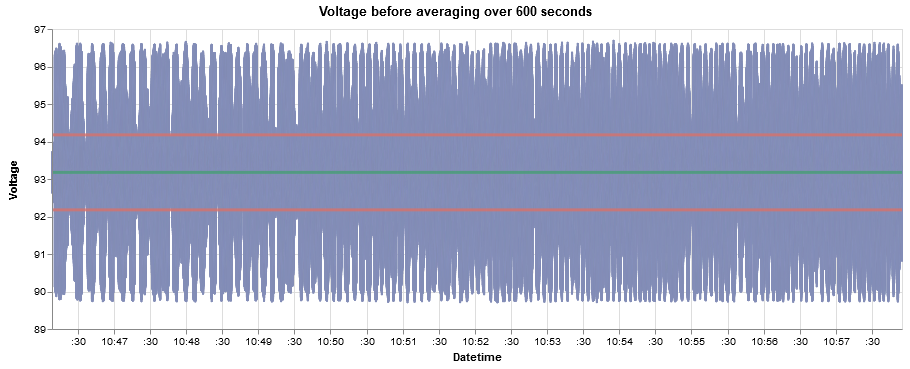

In [5]:
stability_rules_layer = generate_stability_rules(flatten_raw_data)

base_line = alt.Chart().mark_line(color=LINE_COLOUR).encode(
    alt.X("Datetime:T", title="Datetime"),
    alt.Y("Value:Q", scale = alt.Scale(domain=[89, 97]), title="Voltage")
)

alt.layer(base_line, stability_rules_layer, data=flatten_raw_data, 
          title="Voltage before averaging over 600 seconds",
          width=850,
          config={"background": "white"})

In [6]:
raw_mean = np.mean(flatten_raw_data)
raw_mean

Value    93.177092
dtype: float64

In [7]:
raw_std = np.std(flatten_raw_data)
raw_std

Value    2.383439
dtype: float64

The graph above shows how often the signal is outside of the stability parameters set at $\pm1kV$ from the mean. We also see that the signal has a standard deviation of $2.394288kV$ from a mean of $93.176931kV$.

In [8]:
raw_unstable_seconds = unstable_seconds(flatten_raw_data, float(raw_mean))
raw_unstable_seconds

480.55

The number of unstable seconds is 161.87 over this 210 second window.

### Averaging the data

Now we will average the data by averaging values which are 180 degrees apart on the 50Hz wave. As this data was collected while sampling 100 elements at 100Hz (new reading every second) we need to average each pair of elements. We set the timestamp of the average to the later element's timestamp. Assuming the DAQ keeps sampling at 100Hz while sending the data to the IOC, this won't create artifacts at the ends of the packets of data.

In [9]:
averaged_data = average_data(flatten_raw_data)

In [10]:
averaged_data_mean = np.mean(averaged_data)
averaged_data_mean

Value    93.177117
dtype: float64

In [11]:
np.std(averaged_data)

Value    0.151717
dtype: float64

In [12]:
1- np.std(averaged_data)/np.std(flatten_raw_data)

Value    0.936345
dtype: float64

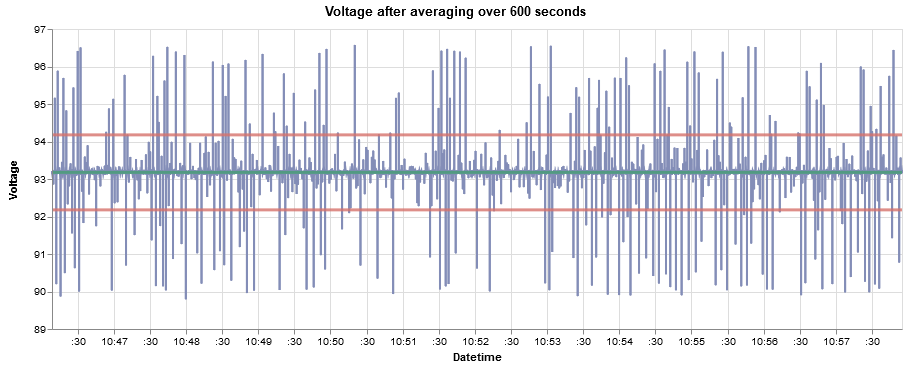

In [13]:
averaged_stability_bounds = generate_stability_rules(averaged_data)

alt.layer(base_line, averaged_stability_bounds, data=averaged_data, 
          title="Voltage after averaging over 600 seconds",
          width=850,
          config={"background": "white"})

The graph above shows how often the signal is outside of the stability parameters set at $\pm1kV$ from the mean. We also see that the signal has a standard deviation of $0.152311kV$ from a mean of $93.177028kV$. This is a $93.6386\%$ reduction of the standard deviation.

In [14]:
averaged_unstable_second = unstable_seconds(averaged_data, float(averaged_data_mean))
averaged_unstable_second

2.07

In [15]:
1 - averaged_unstable_second/raw_unstable_seconds

0.9956924357507023

The number of unstable seconds is 2.07 seconds over this 600 second window- a 99.57% decrease in the amount of time spent unstable.